In [1]:
import numpy as np

In [29]:
a = np.array([[1, 2], [3, 4]])

In [22]:
b = np.array([1,1])

In [23]:
c = np.repeat(b[np.newaxis], 2, 0)

In [24]:
c

array([[1, 1],
       [1, 1]])

In [26]:
b.ndim

1

In [27]:
a-b

array([[0, 1],
       [2, 3]])

In [28]:
a-c

array([[0, 1],
       [2, 3]])

In [34]:
np.sum(a, 1).reshape(-1,1)

array([[3],
       [7]])

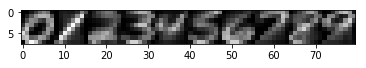

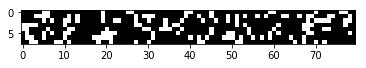

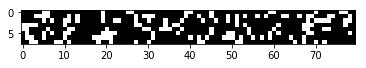

-0.9437538618002541
-0.9872704337253596
0
0


In [50]:
'''
implement and evaluate the Naive Bayes classifier.
'''

import data
import numpy as np
# Import pyplot - plt.imshow is useful!
import matplotlib.pyplot as plt


def binarize_data(pixel_values):
    '''
    Binarize the data by thresholding around 0.5
    '''
    return np.where(pixel_values > 0.5, 1.0, 0.0)

def compute_parameters(train_data, train_labels):
    '''
    Compute the eta MAP estimate/MLE with augmented data

    return a numpy array of shape (10, 64)
    where the ith row corresponds to the ith digit class.
    '''
    eta = np.zeros((10, 64))
    
    N = train_data.shape[0]
    
    total = (N/10)+2
    
    for i in range(N):
        
        index = int (train_labels[i])
        
        eta[index,:] += train_data[i,:]
    
    eta +=1
    eta /= total
        
    
    return eta

def plot_images(class_images):
    '''
    Plot each of the images corresponding to each class side by side in grayscale
    '''
    img = []
    for i in range(10):
        img_i = class_images[i].reshape(8,8)
        img.append(img_i)
        
    img_concat = np.concatenate(img,1)
    plt.imshow(img_concat, cmap='gray')
    plt.show()
    
        
def generate_new_data(eta):
    '''
    Sample a new data point from your generative distribution p(x|y,theta) for
    each value of y in the range 0...10

    Plot these values
    '''
    #generated_data = np.zeros((10, 64))
    
    generated_data = np.random.binomial(1,eta)
    
    
    img = []
    for i in range(10):
        img.append(generated_data[i,:].reshape(8,8))        
    
    img_concat = np.concatenate(img,1)
    plt.imshow(img_concat, cmap='gray')
    plt.show()
        
    
    
    
    
    plot_images(generated_data)

def generative_likelihood(bin_digits, eta):
    '''
    Compute the generative log-likelihood:
        log p(x|y, eta)

    Should return an n x 10 numpy array 
    '''
    num_data = int(bin_digits.shape[0])
    likelihoods = np.zeros((num_data, 10))
    for i in range(num_data):
        for k in range(10):
            for j in range(64):
                left = eta[k, j]**bin_digits[i, j]
                right = (1 - eta[k, j])**(1 - bin_digits[i, j])
                if likelihoods[i, k] == 0:
                    likelihoods[i, k] = left * right
                else:
                    likelihoods[i, k] *= left * right
    likelihoods = np.log(likelihoods)
    return likelihoods

def conditional_likelihood(bin_digits, eta):
    '''
    Compute the conditional likelihood:

        log p(y|x, eta)

    This should be a numpy array of shape (n, 10)
    Where n is the number of datapoints and 10 corresponds to each digit class
    '''
    
    alpha = 0.1
    
    log_gen = generative_likelihood(bin_digits, eta)
    
    gen = np.exp(log_gen)
    
    total_prob = (np.sum((gen*alpha),1)).reshape(-1,1)
    
    log_total = np.log(total_prob)
    
    log_con = log_gen + np.log(0.1) - log_total
    
    return log_con

# def conditional_likelihood(bin_digits, eta):
#     '''
#     Compute the conditional likelihood:

#         log p(y|x, eta)

#     This should be a numpy array of shape (n, 10)
#     Where n is the number of datapoints and 10 corresponds to each digit class

#     p(y|x, eta)=p(x|y, eta)*p(y)/p(x|eta)
#     after log:
#     log p(y|x, eta)=log p(x|y, eta) + log p(y) - log p(x|eta)

#     p(x|eta) =  sum y over p(x, y| eta)
#     '''
#     log_likelihoods = generative_likelihood(bin_digits, eta)
#     likelihoods = np.exp(log_likelihoods)

#     prior = 1/10
#     log_prior = np.log(prior)


#     evi = np.sum(likelihoods, axis=1) * prior
#     log_evi = np.log(evi).reshape(-1, 1)
#     print("log_evi.shape: ", log_evi.shape)

#     cond = log_likelihoods + log_prior - log_evi
#     print("cond.shape: ", cond.shape)

#     return cond


def avg_conditional_likelihood(bin_digits, labels, eta):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, eta) )

    i.e. the average log likelihood that the model assigns to the correct class label
    '''
    cond_likelihood = conditional_likelihood(bin_digits, eta)
    
    N = bin_digits.shape[0]
    total=0
    
    for i in range(N):
        total += cond_likelihood[i,int(labels[i])]
        
    avg = total/N
        
        
    return avg

# def avg_conditional_likelihood(bin_digits, labels, eta):
#     '''
#     Compute the average conditional likelihood over the true class labels

#         AVG( log p(y_i|x_i, eta) )

#     i.e. the average log likelihood that the model assigns to the correct class label
#     '''
#     cond_likelihood = conditional_likelihood(bin_digits, eta)
#     n = len(cond_likelihood)
#     summation = 0
#     for i in range(n):
#         summation += cond_likelihood[i, int(labels[i])]

#     # Compute as described above and return
#     return summation / n
    


def classify_data(bin_digits, eta):
    '''
    Classify new points by taking the most likely posterior class
    '''
    cond_likelihood = conditional_likelihood(bin_digits, eta)
    
    N = bin_digits.shape[0]
    
    class_label = []
    
    for i in range(N):
        
        label = np.argmax(cond_likelihood[i,:])
        
        class_label.append(label)
    
    return class_label

def classification_accuracy(predict, labels):
    '''
    Evaluate the classification accuracy of Gaussian Classifier on the given 'eval_data'
    using the labels
    '''
    
    N = labels.shape[0]
    accuracy=0
    
    for i in range(N):
        if predict[i]==labels[i]:
            accuracy+=1
    
    accuracy /=N
    
    return accuracy


def main():
    train_data, train_labels, test_data, test_labels = data.load_all_data('data')
    train_data, test_data = binarize_data(train_data), binarize_data(test_data)

    # Fit the model
    eta = compute_parameters(train_data, train_labels)

    # Evaluation
    plot_images(eta)

    generate_new_data(eta)
    
    train_avg = avg_conditional_likelihood(train_data, train_labels, eta)
    test_avg = avg_conditional_likelihood(test_data, test_labels, eta)
    print ((train_avg))
    print ((test_avg))
    
    train_post = classify_data(train_data, eta)
    train_a = classification_accuracy(train_post, train_labels)
    print (train_a)
    
    test_post = classify_data(test_data, eta)
    test_a = classification_accuracy(test_post, test_labels)
    print (test_a)
    
    
    
    

if __name__ == '__main__':
    main()